<a href="https://colab.research.google.com/github/issa-project/issa-pipeline/blob/main/notebooks/issa-descriptor-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling of Thematic Descriptors in ISSA dataset

**Comparing human and automated indexation of the document text**  

Use case: Agritrop ISSA

Endpoint: https://data-issa.cirad.fr/sparql

In [1]:
import os
try:
    isColab = os.environ['GCE_METADATA_TIMEOUT']
    if isColab:
        !pip install SPARQLWrapper
except:
    pass

In [2]:
import pandas as pd
import numpy as np
import json
import copy
import math

from SPARQLWrapper import SPARQLWrapper, JSON, POST

import matplotlib.pyplot as plt

from IPython.display import display, display_html

In [22]:
import re
def sparql_service_to_dataframe(service, query, remove_comments=False):
    """
    Helper function to convert SPARQL results into a Pandas DataFrame.
    
    Credit to Ted Lawless https://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    # Remove comments to make a request shorter
    if (remove_comments):
        query = re.sub(r'(?m)^ *#.*\n?', '', query)

    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
    
    return pd.DataFrame(out, columns=cols) 

In [4]:
issa_agritrop_endpoint = 'https://data-issa.cirad.fr/sparql'

## Dataset info

In [5]:
dataset_info_query = '''
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX void:   <http://rdfs.org/ns/void#> 
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX prov: <http://www.w3.org/ns/prov#>

SELECT * WHERE {
  issa:issa-agritrop dct:title ?dataset_name;
                     dct:description ?dataset_description;
                     void:triples ?triple_count;
                     owl:versionInfo ?version;
                     dct:issued ?initial_date;
                     prov:wasGeneratedAtTime ?generated_date.
  
  OPTIONAL{   issa:issa-agritrop dct:modified ?updated_date. }
} 
'''

In [6]:
pd.options.display.max_colwidth = 80
dataset_info = sparql_service_to_dataframe(issa_agritrop_endpoint, dataset_info_query)
dataset_info.transpose()

,0
dataset_name,ISSA Agritrop dataset
dataset_description,This RDF dataset was produced by processing articles from Agritrop - the ope...
triple_count,171783648
version,1.2.20230306
initial_date,2022-04-29
generated_date,2023-03-14
updated_date,2023-03-14


## Sample articles and their descriptors

In [7]:
latest_training_paper_id = 600364

sample_size = 60

seed = 42

In [10]:
articles_ids_query_template = '''
PREFIX dce: <http://purl.org/dc/elements/1.1/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX prov: <http://www.w3.org/ns/prov#>
prefix bibo:   <http://purl.org/ontology/bibo/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX fabio:  <http://purl.org/spar/fabio/>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr:   <http://data-issa.cirad.fr/property/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>

SELECT  distinct ?paperURI ?paperID ?lang
        
FROM <http://data-issa.cirad.fr/graph/documents>
FROM <http://data-issa.cirad.fr/graph/thematic-descriptors>
FROM <http://data-issa.cirad.fr/graph/annif-descriptors>
FROM <http://agrovoc.fao.org/graph>

WHERE {
        ?paperURI dct:identifier ?paperID;
                     dce:language ?lang.
         FILTER ( EXISTS { ?paperURI a bibo:AcademicArticle } )
         FILTER ( xsd:integer(?paperID) > %d )
         FILTER ( EXISTS {  ?descrH oa:hasTarget ?paperURI;
                             prov:wasAttributedTo issa:AgritropDocumentalist. } )
         FILTER ( EXISTS {  ?descrM oa:hasTarget ?paperURI;
                             prov:wasAttributedTo issa:AnnifSubjectIndexer. } )
}
ORDER BY ?paperID
'''

In [11]:
df = sparql_service_to_dataframe(issa_agritrop_endpoint, 
                                 articles_ids_query_template % (latest_training_paper_id ))
df.shape

(323, 3)

In [12]:
print('en', df.loc[df.lang=='eng'].shape)
print('fr', df.loc[df.lang=='fre'].shape)

en (259, 3)
fr (64, 3)


In [13]:
langs = { 'en': 'eng', 
          'fr' :'fre'}

random_paper_ids = {}

random_paper_ids['en'] = df.loc[df.lang=='eng'].sample(n=sample_size//2, random_state= 42)
random_paper_ids['fr'] = df.loc[df.lang=='fre'].sample(n=sample_size//2, random_state= 42)
random_paper_ids['both'] = pd.concat(random_paper_ids.values())

In [14]:
random_paper_ids['both'].sort_values(by='paperID').head()

,paperURI,paperID,lang
5,http://data-issa.cirad.fr/document/600407,600407,fre
8,http://data-issa.cirad.fr/document/600428,600428,eng
11,http://data-issa.cirad.fr/document/600447,600447,eng
18,http://data-issa.cirad.fr/document/600511,600511,fre
19,http://data-issa.cirad.fr/document/600514,600514,eng


In [15]:
paper_descriptors_query_template = '''
PREFIX schema: <http://schema.org/>
PREFIX dce: <http://purl.org/dc/elements/1.1/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX prov: <http://www.w3.org/ns/prov#>
prefix bibo:   <http://purl.org/ontology/bibo/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX fabio:  <http://purl.org/spar/fabio/>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr:   <http://data-issa.cirad.fr/property/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>

SELECT  distinct ?lang ?paperURI ?agritrop_url ?paperID 
                 ?descrUri ?descrLabelEN ?descrLabelFR 
                 ?rankHuman ?rankAnnif ?confAnnif


FROM <http://data-issa.cirad.fr/graph/documents>
FROM <http://data-issa.cirad.fr/graph/thematic-descriptors>
FROM <http://data-issa.cirad.fr/graph/annif-descriptors>
FROM <http://agrovoc.fao.org/graph>

WHERE {
    
  VALUES (?paperURI) { %s }
  
    ?paperURI dct:identifier ?paperID;
           dce:language ?lang;
           schema:url ?agritrop_url.
    
    {
        ?descrHuman a issa:ThematicDescriptorAnnotation;
                    oa:hasBody ?descrUri;
                    oa:hasTarget ?paperURI;
                    issapr:rank  ?rankHuman;
                    prov:wasAttributedTo issa:AgritropDocumentalist.  

        optional {
          ?descrAnnif a issa:ThematicDescriptorAnnotation;
                      oa:hasBody ?descrUri;
                      oa:hasTarget ?paperURI;
                      issapr:rank  ?rankAnnif;
                      issapr:confidence ?confAnnif;
                      prov:wasAttributedTo issa:AnnifSubjectIndexer. }
      }
      UNION
      {
        ?descrAnnif a issa:ThematicDescriptorAnnotation;
                    oa:hasBody?descrUri;
                    oa:hasTarget ?paperURI;
                    issapr:rank  ?rankAnnif;
                    issapr:confidence ?confAnnif;
                    prov:wasAttributedTo issa:AnnifSubjectIndexer.

        optional {
          ?descrHuman a issa:ThematicDescriptorAnnotation;
                      oa:hasBody ?descrUri;
                      oa:hasTarget ?paperURI;
                      issapr:rank  ?rankHuman;
                      prov:wasAttributedTo issa:AgritropDocumentalist  }
      }
      
      FILTER (COALESCE(?rankAnnif , 0) < %d  )  
      FILTER (COALESCE(?confAnnif, 1.0) > %f )  

      OPTIONAL {# Find labels
         ?descrUri skosxl:prefLabel/skosxl:literalForm ?descrLabelEN.
          FILTER langMatches(lang(?descrLabelEN), "en") }
  
      OPTIONAL {# Find labels
         ?descrUri skosxl:prefLabel/skosxl:literalForm ?descrLabelFR.
          FILTER langMatches(lang(?descrLabelFR), "fr") }
}
ORDER BY ?lang ?paperURI ?rankHuman ?rankAnnif
'''

In [16]:
values = ' '.join(['(<%s>)' % x for x in random_paper_ids['both'].paperURI])
max_rank = 15
min_conf = 0.1

df = sparql_service_to_dataframe(issa_agritrop_endpoint, 
                                 paper_descriptors_query_template % (values, 
                                                                     max_rank+1, min_conf ) )  
df.shape

(974, 10)

In [17]:
pd.options.display.float_format = '{:,.2f}'.format
#pd.options.display.max_colwidth = None

df= df.astype({'paperID': 'int',
                'rankHuman': 'float',
                'rankAnnif': 'float',
                'confAnnif': 'float'})

df = df.sort_values(by=['lang', 'paperURI', 'rankHuman', 'rankAnnif' ])\
  #.head(20)

In [83]:
df.head()

,lang,paperURI,agritrop_url,paperID,descrUri,descrLabelEN,descrLabelFR,rankHuman,rankAnnif,confAnnif
9,eng,http://data-issa.cirad.fr/document/600428,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_2395,drugs,médicament,1.00,NaN,NaN
10,eng,http://data-issa.cirad.fr/document/600428,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_9fbe9719,supply chains,chaîne d'approvisionnement,2.00,2.00,0.33
11,eng,http://data-issa.cirad.fr/document/600428,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_431,animal health,santé animale,3.00,1.00,0.42
12,eng,http://data-issa.cirad.fr/document/600428,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_8206,veterinary medicine,médecine vétérinaire,4.00,14.00,0.12
13,eng,http://data-issa.cirad.fr/document/600428,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_32496,health policies,politique sanitaire,5.00,8.00,0.18


In [16]:
df.to_csv('sample of indexed articles.csv' , encoding='utf-8',
          index=False, float_format='%.2f')

Save data frame in the format requested by Anne

In [86]:
df_adapted = copy.deepcopy(df)
df_adapted.insert(2, 'Visualisation enrichie', df_adapted.paperURI.apply(lambda x: 'http://erebe-vm3.i3s.unice.fr/visu/?uri=%s' % x) )

df_adapted['Manual'] = df_adapted.rankHuman.apply(lambda x: '' if math.isnan(x) else 'x')
df_adapted['Annif']  = df_adapted.rankAnnif.apply(lambda x: '' if math.isnan(x) else 'x')


df_adapted.drop(columns=['paperURI', 'rankHuman', 'rankAnnif', 'confAnnif'], inplace= True)

df_adapted.head()

,lang,Visualisation enrichie,agritrop_url,paperID,descrUri,descrLabelEN,descrLabelFR,Manual,Annif
9,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/6...,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_2395,drugs,médicament,x,
10,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/6...,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_9fbe9719,supply chains,chaîne d'approvisionnement,x,x
11,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/6...,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_431,animal health,santé animale,x,x
12,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/6...,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_8206,veterinary medicine,médecine vétérinaire,x,x
13,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/6...,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_32496,health policies,politique sanitaire,x,x


In [87]:
df_adapted.to_csv('sample of indexed articles.csv' , encoding='utf-8', index=False)
del df_adapted

## Calculate metrics 
simple way to calculate jaccard similarity

In [40]:
df.loc[df.rankHuman.notna() & df.rankAnnif.notna()].groupby('paperID').size() / df.groupby('paperID').size()

paperID
600407   0.31
600428   0.33
600447   0.42
600511   0.30
600514   0.29
600637   0.47
600639   0.11
600640   0.21
600647   0.29
600660   0.07
600690   0.21
600702   0.31
600745   0.20
600830   0.08
600836   0.19
600919   0.19
600988   0.19
601003   0.14
601012   0.27
601023   0.17
601037   0.20
601118   0.26
601239   0.44
601246   0.19
601259   0.25
601291   0.08
601363   0.06
601409   0.11
601417   0.21
601453   0.24
601484   0.22
601501   0.13
601506    NaN
601507   0.08
601537   0.25
601562   0.20
601677   0.11
601706   0.27
601755   0.38
601770   0.11
602008   0.10
602321   0.22
602347   0.13
602349   0.11
602399   0.24
602501   0.25
602583   0.20
602588   0.24
602594   0.11
602977   0.08
602997   0.26
603009   0.29
603097   0.26
603263   0.17
603360   0.33
603542   0.07
603544   0.21
603575    NaN
603859   0.09
603862   0.40
dtype: float64

Calculate metrcis using scikit-learn. it requires more dataprep but at the end more flexible.

In [18]:
from sklearn import metrics

def _one_hot(rank):
    return list(rank.apply(lambda x: 0 if math.isnan(x) else 1) ) 

df_calc = df.groupby(by='paperID').agg({'rankHuman': _one_hot,
                                        'rankAnnif': _one_hot,
                                        'descrLabelEN' : list})

df_calc['jc'] = df_calc.apply( lambda x: metrics.jaccard_score(x.rankHuman, x.rankAnnif), axis=1 )
df_calc['f1'] = df_calc.apply( lambda x: metrics.f1_score(x.rankHuman, x.rankAnnif), axis=1 )
df_calc['recall'] = df_calc.apply( lambda x: metrics.recall_score(x.rankHuman, x.rankAnnif), axis=1 )
# precision_score. recall_score

df_calc.head()

,rankHuman,rankAnnif,descrLabelEN,jc,f1,recall
paperID,,,,,,
600407,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[agroecology, crop production, production systems, cropping systems, crop pe...",0.31,0.48,0.56
600428,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[drugs, supply chains, animal health, veterinary medicine, health policies, ...",0.33,0.50,0.83
600447,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]","[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]","[peptide synthetases, peptides, polypeptides, biosynthesis, secondary metabo...",0.42,0.59,0.56
600511,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[agricultural practices, Arthropoda, agroecosystems, soil biology, agroecolo...",0.30,0.46,0.55
600514,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[forest plantations, reforestation, climate change adaptation, climate chang...",0.29,0.44,0.67


<AxesSubplot:>

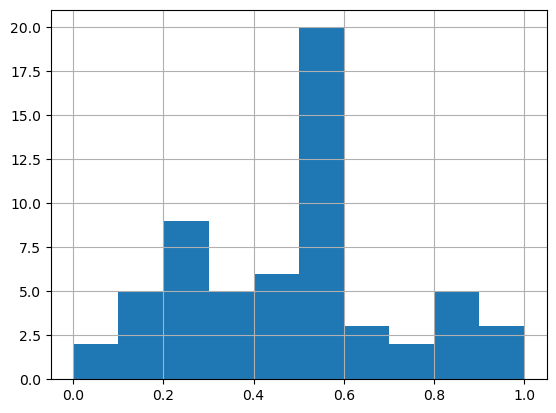

In [19]:
df_calc.recall.hist()

## Extend with hierarchy

In [20]:
# relative to Annif descriptors
ancestors_depth = 1
descendants_depth = 10

In [23]:
find_annif_descr_as_descendant_of_manual_descr_query_templ = '''
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>

# Finding manual descriptor among the parents of Annif's descriptors

SELECT distinct ?paperURI ?annifDescrUri ?annifDescrLabelEN 
                          ("descendantOf" as ?relation)
                          ?manualDescrUri ?manualDescrLabelEN 
                          
FROM <http://agrovoc.fao.org/graph>

WHERE {
  
  VALUES (?paperURI) { (<%s>) }
  VALUES (?annifDescrUri) { %s }
  VALUES (?manualDescrUri) { %s }
  
  ?annifDescrUri skos:broader{1,%d} ?annifDescrParentUri.
  
  FILTER (?manualDescrUri = ?annifDescrParentUri)     
  
  ######################################################################
  # Find labels
  OPTIONAL {
    ?manualDescrUri skosxl:prefLabel/skosxl:literalForm ?manualDescrLabelEN;
                    skosxl:prefLabel/skosxl:literalForm ?manualDescrLabelFR.
    FILTER langMatches(lang(?manualDescrLabelEN), "en") 
    FILTER langMatches(lang(?manualDescrLabelFR), "fr") 
  }
  OPTIONAL  { 
    ?annifDescrUri  skosxl:prefLabel/skosxl:literalForm ?annifDescrLabelEN;
                    skosxl:prefLabel/skosxl:literalForm ?annifDescrLabelFR. 
    FILTER langMatches(lang(?annifDescrLabelEN), "en") 
    FILTER langMatches(lang(?annifDescrLabelFR), "fr") 
  }

}
'''

find_annif_descr_as_ancestors_of_manual_descr_query_templ = '''
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>

# Finding manual descriptor among the parents of Annif's descriptors

SELECT distinct ?paperURI ?annifDescrUri ?annifDescrLabelEN
                          ("ancestorOf" as ?relation)
                          ?manualDescrUri ?manualDescrLabelEN 

FROM <http://agrovoc.fao.org/graph>

WHERE {
  
  VALUES (?paperURI) { (<%s>) }
  VALUES (?annifDescrUri) { %s }
  VALUES (?manualDescrUri) { %s }
  
  ?manualDescrUri skos:broader{1,%d} ?manualDescrParentUri.
  
  FILTER (?annifDescrUri = ?manualDescrParentUri)     
  
  ######################################################################
  # Find labels
  OPTIONAL {
    ?manualDescrUri skosxl:prefLabel/skosxl:literalForm ?manualDescrLabelEN;
                    skosxl:prefLabel/skosxl:literalForm ?manualDescrLabelFR.
    FILTER langMatches(lang(?manualDescrLabelEN), "en") 
    FILTER langMatches(lang(?manualDescrLabelFR), "fr") 
  }
  OPTIONAL  { 
    ?annifDescrUri  skosxl:prefLabel/skosxl:literalForm ?annifDescrLabelEN;
                    skosxl:prefLabel/skosxl:literalForm ?annifDescrLabelFR. 
    FILTER langMatches(lang(?annifDescrLabelEN), "en") 
    FILTER langMatches(lang(?annifDescrLabelFR), "fr") 
  }

}
'''

In [99]:
df_extend = {'ancestors': pd.DataFrame(),
             'descendants' : pd.DataFrame()}   

for paper in  df.paperURI.unique():
    
    unmatched_manual_descr = df.loc[(df.paperURI == paper) & df.rankHuman.notna()]# & df.rankAnnif.isna()]
    unmatched_annif_descr  = df.loc[(df.paperURI == paper) & df.rankHuman.isna()  & df.rankAnnif.notna()]
    
    manual_descr_values = ' '.join(['(<%s>)' % x for x in unmatched_manual_descr.descrUri])
    annif_descr_values = ' '.join(['(<%s>)' % x for x in unmatched_annif_descr.descrUri])
    
    # get ancestorsOf
    df_plus = sparql_service_to_dataframe(issa_agritrop_endpoint, 
                                         find_annif_descr_as_descendant_of_manual_descr_query_templ % (paper,
                                                                                                       annif_descr_values,
                                                                                                       manual_descr_values,
                                                                                                       descendants_depth  ) ) 
    
    df_extend['descendants'] = pd.concat([df_extend['descendants'], df_plus], ignore_index=True) 
    if (df_plus.shape[0] > 0):
        print(paper, df_plus.shape) 
    
    # get descedantsOf    
    df_plus = sparql_service_to_dataframe(issa_agritrop_endpoint, 
                                         find_annif_descr_as_ancestors_of_manual_descr_query_templ % (paper,
                                                                                                      annif_descr_values,
                                                                                                      manual_descr_values,
                                                                                                      ancestors_depth     ) ) 
    df_extend['ancestors'] = pd.concat([df_extend['ancestors'], df_plus], ignore_index=True ) 
    if (df_plus.shape[0] > 0):
        print(paper, df_plus.shape) 

print('ancestors :', df_extend['ancestors'].shape)
print('descendants :', df_extend['descendants'].shape)

http://data-issa.cirad.fr/document/600428 (2, 6)
http://data-issa.cirad.fr/document/600428 (1, 6)
http://data-issa.cirad.fr/document/600447 (1, 6)
http://data-issa.cirad.fr/document/600702 (2, 6)
http://data-issa.cirad.fr/document/600745 (1, 6)
http://data-issa.cirad.fr/document/600830 (2, 6)
http://data-issa.cirad.fr/document/600836 (1, 6)
http://data-issa.cirad.fr/document/600836 (1, 6)
http://data-issa.cirad.fr/document/600919 (1, 6)
http://data-issa.cirad.fr/document/601012 (1, 6)
http://data-issa.cirad.fr/document/601023 (4, 6)
http://data-issa.cirad.fr/document/601023 (1, 6)
http://data-issa.cirad.fr/document/601037 (9, 6)
http://data-issa.cirad.fr/document/601118 (2, 6)
http://data-issa.cirad.fr/document/601239 (1, 6)
http://data-issa.cirad.fr/document/601409 (1, 6)
http://data-issa.cirad.fr/document/601409 (1, 6)
http://data-issa.cirad.fr/document/601453 (1, 6)
http://data-issa.cirad.fr/document/601501 (1, 6)
http://data-issa.cirad.fr/document/601501 (2, 6)
http://data-issa.cir

In [68]:
#intersection  = pd.merge(df_extend['ancestors'], temp, how='inner',on=['paperURI', 'annifDescrUri'])
#union         = pd.merge(df_extend['ancestors'], temp, how='outer',on=['paperURI', 'annifDescrUri'])   
#union[union.isnull().any(axis=1)]

In [108]:
df_extend.pop('all', '')
df_extend['all'] = pd.concat(df_extend.values(), ignore_index=True)
    
print('all :', df_extend['all'].shape)

all : (80, 6)


In [109]:
# get the rank and conf values from original dataframe
df_extend['all'] = df_extend['all'].merge(df.loc[: , ['paperURI', 'descrUri', 'rankHuman']], 
                               left_on=['paperURI', 'manualDescrUri'],
                               right_on=['paperURI', 'descrUri'],
                               how='inner')

df_extend['all'] = df_extend['all'].merge(df.loc[: , ['paperURI', 'descrUri', 'rankAnnif', 'confAnnif']], 
                               left_on=['paperURI', 'annifDescrUri'],
                               right_on=['paperURI', 'descrUri'],
                               how='inner')

df_extend['all'].drop(columns=['descrUri_x', 'descrUri_y'], inplace=True)
df_extend['all'].rename(columns={"rankHuman": "rankHumanR"}, inplace=True)

In [110]:
df_extend['all'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 79
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   paperURI            80 non-null     object 
 1   annifDescrUri       80 non-null     object 
 2   annifDescrLabelEN   80 non-null     object 
 3   relation            80 non-null     object 
 4   manualDescrUri      80 non-null     object 
 5   manualDescrLabelEN  80 non-null     object 
 6   rankHumanR          80 non-null     float64
 7   rankAnnif           80 non-null     float64
 8   confAnnif           80 non-null     float64
dtypes: float64(3), object(6)
memory usage: 6.2+ KB


In [111]:
# merge extended matches with original

df_ext = df.merge(df_extend['all'].loc[:, ['paperURI', 'annifDescrUri', 'relation', 'manualDescrLabelEN', 'rankHumanR']],
                           right_on=['paperURI', 'annifDescrUri'],
                           left_on=['paperURI', 'descrUri'],
                       how='left')

df_ext.drop(columns=['annifDescrUri'], inplace=True)
df_ext['rankHumanExt'] = df_ext.rankHuman.combine_first(df_ext.rankHumanR)


Save 

In [112]:
df_ext.head()

,lang,paperURI,agritrop_url,paperID,descrUri,descrLabelEN,descrLabelFR,rankHuman,rankAnnif,confAnnif,relation,manualDescrLabelEN,rankHumanR,rankHumanExt
0,eng,http://data-issa.cirad.fr/document/600428,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_2395,drugs,médicament,1.00,NaN,NaN,NaN,NaN,NaN,1.00
1,eng,http://data-issa.cirad.fr/document/600428,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_9fbe9719,supply chains,chaîne d'approvisionnement,2.00,2.00,0.33,NaN,NaN,NaN,2.00
2,eng,http://data-issa.cirad.fr/document/600428,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_431,animal health,santé animale,3.00,1.00,0.42,NaN,NaN,NaN,3.00
3,eng,http://data-issa.cirad.fr/document/600428,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_8206,veterinary medicine,médecine vétérinaire,4.00,14.00,0.12,NaN,NaN,NaN,4.00
4,eng,http://data-issa.cirad.fr/document/600428,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_32496,health policies,politique sanitaire,5.00,8.00,0.18,NaN,NaN,NaN,5.00


In [73]:
df_ext.to_csv('sample of indexed articles.with hierarchy.csv' , encoding='utf-8',
          index=False, float_format='%.2f')

In [115]:
df_adapted = copy.deepcopy(df_ext)
df_adapted.insert(2, 'Visualisation enrichie', df_adapted.paperURI.apply(lambda x: 'http://erebe-vm3.i3s.unice.fr/visu/?uri=%s' % x) )

df_adapted['Manual'] = df_adapted.apply(lambda r: '' if math.isnan(r.rankHumanExt) else ('x' if math.isnan(r.rankHumanR) else '*' ) , axis=1)
df_adapted['Annif']  = df_adapted.rankAnnif.apply(lambda x: '' if math.isnan(x) else 'x')

df_adapted.drop(columns=['paperURI', 'rankHuman', 'rankAnnif', 'confAnnif', 'rankHumanR', 'rankHumanExt'], inplace=True)
df_adapted.head()

,lang,Visualisation enrichie,agritrop_url,paperID,descrUri,descrLabelEN,descrLabelFR,relation,manualDescrLabelEN,Manual,Annif
0,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/6...,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_2395,drugs,médicament,NaN,NaN,x,
1,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/6...,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_9fbe9719,supply chains,chaîne d'approvisionnement,NaN,NaN,x,x
2,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/6...,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_431,animal health,santé animale,NaN,NaN,x,x
3,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/6...,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_8206,veterinary medicine,médecine vétérinaire,NaN,NaN,x,x
4,eng,http://erebe-vm3.i3s.unice.fr/visu/?uri=http://data-issa.cirad.fr/document/6...,http://agritrop.cirad.fr/600428/,600428,http://aims.fao.org/aos/agrovoc/c_32496,health policies,politique sanitaire,NaN,NaN,x,x


In [116]:
df_adapted.to_csv('sample of indexed articles.with hierarchy.adapted.csv' , encoding='utf-8', index=False)
del df_adapted

## Recalculate metrics

In [81]:
df_calc = df_ext.drop_duplicates(subset=['paperID', 'descrUri'])\
                .groupby(by='paperID').agg({
                                            'lang' : (lambda x: list(x)[0] ),
                                            'rankHuman': _one_hot,
                                            'rankHumanExt': _one_hot,
                                            'rankAnnif': _one_hot,
                                            'descrLabelEN' : list})

df_calc['JaccardIndex'] = df_calc.apply( lambda x: metrics.jaccard_score(x.rankHuman, x.rankAnnif), axis=1 )
df_calc['JaccardIndex_ext'] = df_calc.apply( lambda x: metrics.jaccard_score(x.rankHumanExt, x.rankAnnif), axis=1 )

df_calc['F1'] = df_calc.apply( lambda x: metrics.f1_score(x.rankHuman, x.rankAnnif), axis=1 )
df_calc['F1_ext'] = df_calc.apply( lambda x: metrics.f1_score(x.rankHumanExt, x.rankAnnif), axis=1 )

df_calc['Recall'] = df_calc.apply( lambda x: metrics.recall_score(x.rankHuman, x.rankAnnif), axis=1 )
df_calc['Recall_ext'] = df_calc.apply( lambda x: metrics.recall_score(x.rankHumanExt, x.rankAnnif), axis=1 )

df_calc['Precision'] = df_calc.apply( lambda x: metrics.precision_score(x.rankHuman, x.rankAnnif), axis=1 )
df_calc['Precision_ext'] = df_calc.apply( lambda x: metrics.precision_score(x.rankHumanExt, x.rankAnnif), axis=1 )

# precision_score. recall_score

df_calc.shape

(60, 13)

In [75]:
df_calc.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
JaccardIndex,60.00,0.20,0.11,0.00,0.11,0.21,0.26,0.47
JaccardIndex_ext,60.00,0.28,0.13,0.00,0.20,0.27,0.36,0.53
F1,60.00,0.33,0.14,0.00,0.20,0.34,0.42,0.64
F1_ext,60.00,0.42,0.16,0.00,0.33,0.42,0.53,0.70
Recall,60.00,0.47,0.24,0.00,0.27,0.50,0.58,1.00
Recall_ext,60.00,0.54,0.23,0.00,0.37,0.56,0.67,1.00
Precision,60.00,0.29,0.19,0.00,0.15,0.27,0.38,1.00
Precision_ext,60.00,0.39,0.20,0.00,0.27,0.40,0.50,1.00


Save

In [86]:
df_calc.drop(columns=['rankHuman', 'rankHumanExt', 'rankAnnif','descrLabelEN'])\
    .to_csv('metrics for sample of indexed articles.with hierarchy.csv' , encoding='utf-8',
          index=True, float_format='%.2f')

Visualize

In [32]:
def summary_dataframe(df_metrics, col_prefix='', col_suffix='', from_id=0, title=''):
    df_summary = pd.DataFrame(columns=['language', 'Recall', 'Precision', 'F1 score', 'Jaccard Index'])

    df_summary['language'] = df_metrics.keys() #pd.Series(['en', 'fr', 'both'])
    df_summary.set_index('language', inplace=True)
    df_summary.columns.name = title
    
    #sr_count = pd.Series(data=[0,0,0], index=['en', 'fr', 'both'], dtype='int')
    sr_count = pd.Series(data=[0] * len(df_metrics), index=df_metrics.keys(), dtype='int')
    
    df_metrics_view = df_metrics.copy()
    #df_metrics_view['both'] = pd.concat(df_metrics_view.values() )

    for lang, df in df_metrics_view.items():
        df = df.loc[df.paperID > from_id,]
        sr_count[lang] = df.shape[0]
        df_summary.loc[lang , 'F1 score'] = df.F1.mean()
        df_summary.loc[lang , 'Recall'] = df.Recall.mean()
        df_summary.loc[lang , 'Precision'] = df.Precision.mean()
        df_summary.loc[lang , 'Jaccard Index'] = df.JaccardIndex.mean()


    df_summary.rename(columns= dict(zip(df_summary.columns, [ col_prefix  + 'avg. '+  c + col_suffix for c in df_summary.columns])),
                            inplace=True)
    
    df_summary.insert(0, 'Docs', sr_count)
                                
    return df_summary 


In [117]:
df_calc.reset_index(inplace=True)

df_metrics = {'en' : df_calc.loc[df_calc.lang == 'eng'],
              'fr' : df_calc.loc[df_calc.lang == 'fre'],
              'both' : df_calc}

col_h = ['paperID', 'lang'] + [col for col in df_calc.columns if '_ext' in col]

renaming = {col: col.split('_')[0] for col in df_calc.columns if '_ext' in col}

df_metrics_h = {'en' : df_calc.loc[df_calc.lang == 'eng', col_h].rename(columns=renaming) ,
                'fr' : df_calc.loc[df_calc.lang == 'fre', col_h].rename(columns=renaming),
                'both' : df_calc.loc[:, col_h].rename(columns=renaming)}

summary_dataframe(df_metrics_h)
table_style = [{"selector": "", "props": [("border", "3px solid yellow !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]

pd.concat([summary_dataframe(df_metrics).transpose(), summary_dataframe(df_metrics_h).transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([summary_dataframe(df_metrics).columns.sort_values(), ['', '+hierarchy',]])) \
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Metriccs for the sample set') \
     .highlight_max(subset='avg. F1 score', color='lightyellow', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightyellow', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightyellow', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightyellow', axis=1)

## Calculate metrics in SPARQL

In [128]:
quality_metrics_short_query_template = '''
PREFIX dce: <http://purl.org/dc/elements/1.1/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX prov: <http://www.w3.org/ns/prov#>
prefix bibo:   <http://purl.org/ontology/bibo/>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX fabio:  <http://purl.org/spar/fabio/>
PREFIX oa:     <http://www.w3.org/ns/oa#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX issa:   <http://data-issa.cirad.fr/>
PREFIX issapr:   <http://data-issa.cirad.fr/property/>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX skosxl: <http://www.w3.org/2008/05/skos-xl#>

SELECT  ?lang
        (?paper AS ?paperURI) ?paperID 
        ?TP ?FN ?FP ?UNION
        (?TP / (xsd:float( ?TP + ?FN) + 0.000001)  as ?Recall)
        (?TP / (xsd:float( ?TP + ?FP) + 0.000001)  as ?Precision)
        ( 2 * ?Precision * ?Recall / (?Precision + ?Recall + 0.000001) as ?F1)
        ( ?TP / xsd:float(?UNION) as ?JaccardIndex)

FROM <http://data-issa.cirad.fr/graph/documents>
FROM <http://data-issa.cirad.fr/graph/thematic-descriptors>
FROM <http://data-issa.cirad.fr/graph/annif-descriptors>
FROM <http://agrovoc.fao.org/graph>

WHERE {
  SELECT  ?paper ?paperID
          (sum(?tp) as ?TP)
          (sum(?fn) as ?FN)
          (sum(?fp) as ?FP)
          (count (distinct ?descrUri) as ?UNION)
          (SAMPLE(?lang) AS ?lang)

  WHERE { 
    # need this encapsulating select to eliminate the same parents 
    
    SELECT  ?paper ?paperID ?descrUri 
            (MAX(?tp) as ?tp) 
            (MIN(?fp) AS ?fp) 
            (MIN(?fn) as ?fn) 
            (SAMPLE(?lang) AS ?lang)
 
    WHERE {
      VALUES (?paper) { %s }
      #VALUES (?paper) { (<http://data-issa.cirad.fr/document/600248>) }
      
      ?paper dct:identifier ?paperID;
             dce:language ?lang.
             FILTER (%s EXISTS { ?paper a bibo:AcademicArticle } )
      {
        # Match manual descriptors to automatic descriptors
        ?descrHuman a issa:ThematicDescriptorAnnotation;
                    oa:hasBody ?descrUri;
                    oa:hasTarget ?paper;
                    issapr:rank  ?rankHuman;
                    prov:wasAttributedTo issa:AgritropDocumentalist.  
        optional {
          ?descrAnnif a issa:ThematicDescriptorAnnotation;
                      oa:hasBody ?descrUri;
                      oa:hasTarget ?paper;
                      issapr:rank  ?rankAnnif;
                      issapr:confidence  ?confAnnif;
                      prov:wasAttributedTo issa:AnnifSubjectIndexer. }
    }
    UNION
    {
    	# Match automatic descriptors with children (descendants) or patents(descendants) of manual descriptors 
        ?descrAnnif a issa:ThematicDescriptorAnnotation;
                    oa:hasBody?descrUri;
                    oa:hasTarget ?paper;
                    issapr:rank  ?rankAnnif;
                    issapr:confidence  ?confAnnif;
                    prov:wasAttributedTo issa:AnnifSubjectIndexer.

        optional {
          ?descrHuman a issa:ThematicDescriptorAnnotation;
                      # {0, 0} = match
                      # {0, 1} = immediate child/parent
                      # {0, 10} = 10 levels of hierarchy up ior down 
                      # narrower does not work, use ^boroader
                      oa:hasBody | oa:hasBody/skos:broader{0,%d} | oa:hasBody/^skos:broader{0,%d} ?descrUri; #narrower does not work
                      oa:hasBody ?descrUriOrig;
                      oa:hasTarget ?paper;
                      issapr:rank  ?rankHuman;
                      prov:wasAttributedTo issa:AgritropDocumentalist  }
          
      }

    bind (IF( BOUND(?descrHuman) &&  BOUND(?descrAnnif), 1, 0 ) as ?tp)
    bind (IF( BOUND(?descrHuman) &&  !BOUND(?descrAnnif), 1, 0 ) as ?fn)
    bind (IF( !BOUND(?descrHuman) &&  BOUND(?descrAnnif), 1, 0 ) as ?fp)
    
    FILTER (COALESCE(?rankAnnif , 0) < %d  )  
    FILTER (COALESCE(?confAnnif, 1.0) > %f )  
  
 }
 group by ?paper ?paperID ?descrUri ?descrLabel 
}
group by ?paper ?paperID
# select only the papers that have at least some number of uman descriptors
having ((sum(?tp) + sum(?fn)) > %d   ) 
}
order by ?paperID
'''

In [153]:
def query_metrics(paper_list, articles_only=True, 
                              ancestors_depth=0,   # (1)
                              descendants_depth=0, # (10)
                              topK_annif=15,
                              min_conf= 0.1,
                              min_manual = 1):

    values = ' '.join(['(<%s>)' % x for x in paper_list])
    subset = ' ' if articles_only else 'NOT'
    
    query = quality_metrics_short_query_template % (values ,
                                                  subset,
                                                  ancestors_depth, 
                                                  descendants_depth, 
                                                  topK_annif + 1, min_conf,
                                                  min_manual - 1 )
    
    #print(query)
   
    df= sparql_service_to_dataframe(issa_agritrop_endpoint, query, remove_comments=True)

    df= df.astype({'paperID': 'int',
                    'TP': 'float',
                    'FN': 'float',
                    'FP': 'float',
                    'Recall': 'float',
                    'Precision': 'float',
                    'F1': 'float',
                    'JaccardIndex': 'float' })
    print(df.shape)

    return df

In [142]:
ancestors_depth  = 1
descendants_depth = 10

topK_annif = 15
min_manual = 3

min_conf = 0.1

In [143]:
# exact match
metrics_df = {'en' : query_metrics(random_paper_ids['en'].paperURI, min_manual=min_manual),
              'fr' : query_metrics(random_paper_ids['fr'].paperURI, min_manual=min_manual) }

metrics_df['both'] = pd.concat(metrics_df.values())
              
metrics_df['both'].shape

(29, 11)
(29, 11)


(58, 11)

In [144]:
# match with hhoerarchy
metrics_df_h = {'en' : query_metrics(random_paper_ids['en'].paperURI, ancestors_depth=1, descendants_depth=10, 
                                                                      min_manual=min_manual),
                'fr' : query_metrics(random_paper_ids['fr'].paperURI, ancestors_depth=1, descendants_depth=10,
                                                                      min_manual=min_manual) }

metrics_df_h['both'] = pd.concat(metrics_df_h.values())
              
metrics_df_h['both'].shape

(29, 11)
(29, 11)


(58, 11)

In [139]:
metrics_df['both'].sort_values(by=['paperID']).head()

,lang,paperURI,paperID,TP,FN,FP,UNION,Recall,Precision,F1,JaccardIndex
0,fre,http://data-issa.cirad.fr/document/600407,600407,5.00,4.00,7.00,16,0.56,0.42,0.48,0.31
0,eng,http://data-issa.cirad.fr/document/600428,600428,5.00,1.00,9.00,15,0.83,0.36,0.50,0.33
1,eng,http://data-issa.cirad.fr/document/600447,600447,5.00,4.00,3.00,12,0.56,0.62,0.59,0.42
1,fre,http://data-issa.cirad.fr/document/600511,600511,6.00,5.00,9.00,20,0.55,0.40,0.46,0.30
2,eng,http://data-issa.cirad.fr/document/600514,600514,4.00,2.00,8.00,14,0.67,0.33,0.44,0.29


In [151]:
# Verify against sklearn
pd.merge(metrics_df['both'].loc[:, ['paperID', 'TP', 'UNION', 'Recall']], 
         df_metrics['both'].loc[:, ['paperID', 'Recall']] ,
         on = 'paperID', how='inner').sort_values('paperID')

,paperID,TP,UNION,Recall_x,Recall_y
29,600407,5.00,16,0.56,0.56
0,600428,5.00,15,0.83,0.83
1,600447,5.00,12,0.56,0.56
30,600511,6.00,20,0.55,0.55
2,600514,4.00,14,0.67,0.67
31,600637,7.00,15,1.00,1.00
32,600639,2.00,18,0.18,0.18
33,600640,4.00,19,0.50,0.50
34,600647,5.00,17,0.62,0.62
35,600690,4.00,19,0.40,0.40


In [152]:
table_style = [{"selector": "", "props": [("border", "3px solid yellow !important")]},
               {"selector": "td", "props": [("border", "1px solid grey !important")]},
               {"selector": "th", "props": [("border", "1px solid grey !important")]}  ]

pd.concat([summary_dataframe(metrics_df).transpose(), summary_dataframe(metrics_df_h).transpose()], axis=0) \
     .sort_index() \
     .set_index(pd.MultiIndex.from_product([summary_dataframe(df_metrics).columns.sort_values(), ['', '+hierarchy',]])) \
          .round(2) \
     .transpose() \
     .style.set_table_styles(table_style) \
     .format(precision=2) \
     .set_caption('Metriccs for the sample set') \
     .highlight_max(subset='avg. F1 score', color='lightyellow', axis=1) \
     .highlight_max(subset='avg. Jaccard Index', color='lightyellow', axis=1) \
     .highlight_max(subset='avg. Precision', color='lightyellow', axis=1) \
     .highlight_max(subset='avg. Recall', color='lightyellow', axis=1)